In [100]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data.csv')
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),Day of Week
0,2020-05-26,9099.75,9161.65,8996.65,9029.05,654959960.0,30871.59,Tuesday
1,2020-05-27,9082.20,9334.00,9004.25,9314.95,763492487.0,34603.88,Wednesday
2,2020-05-28,9364.95,9511.25,9336.50,9490.10,837911425.0,37761.91,Thursday
3,2020-05-29,9422.20,9598.85,9376.90,9580.30,967005438.0,45006.25,Friday
4,2020-06-01,9726.85,9931.60,9706.95,9826.15,794183122.0,38096.92,Monday


### 1. Making Chunks

In [102]:
def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_columns = ['Open', 'Close', 'High', 'Low']
day_chunks = [5, 15, 30, 45, 60, 90, 120, 150 ,200, 250, 300]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

### 2. Defining Model

In [105]:
models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("RandomForest", RandomForestRegressor()),
    ("GradientBoosting", GradientBoostingRegressor()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor()),
    ("XGBoost", XGBRegressor(verbosity=0)),
    ("LightGBM", LGBMRegressor(verbosity=0))
]

### 3. Model Training

In [106]:
trained_models = {}

for X,y in tqdm(chunk_pairs):

  for model_name, model in models:

    model.fit(chunked_data[X],chunked_data[y])

    y_pred = model.predict(chunked_data[X])

    mae = mean_absolute_error(chunked_data[y], y_pred)
    mse = mean_squared_error(chunked_data[y], y_pred)
    rmse = np.sqrt(mse)

    trained_models[model_name + '_' + X[2:]] = {'model' : model, 'mae' : mae, 'mse' : mse , 'rmse' : rmse}

  0%|          | 0/32 [00:00<?, ?it/s]

In [123]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()
])

results_df

,Model,model,mae,mse,rmse
0,LinearRegression_Open_5,LinearRegression(),129.558609,3.214983e+04,179.303735
1,Ridge_Open_5,Ridge(),129.558609,3.214983e+04,179.303735
2,Lasso_Open_5,Lasso(),133.706788,3.367865e+04,183.517429
3,RandomForest_Open_5,"(DecisionTreeRegressor(max_features=1.0, rando...",54.029897,5.413094e+03,73.573731
4,GradientBoosting_Open_5,([DecisionTreeRegressor(criterion='friedman_ms...,100.362439,1.801805e+04,134.231323
...,...,...,...,...,...
283,GradientBoosting_Low_200,([DecisionTreeRegressor(criterion='friedman_ms...,83.724123,1.195110e+04,109.321080
284,SVR_Low_200,SVR(),2437.602144,9.558166e+06,3091.628371
285,KNN_Low_200,KNeighborsRegressor(),84.581671,1.351090e+04,116.236403
286,XGBoost_Low_200,"XGBRegressor(base_score=None, booster=None, ca...",5.890406,5.975907e+01,7.730399


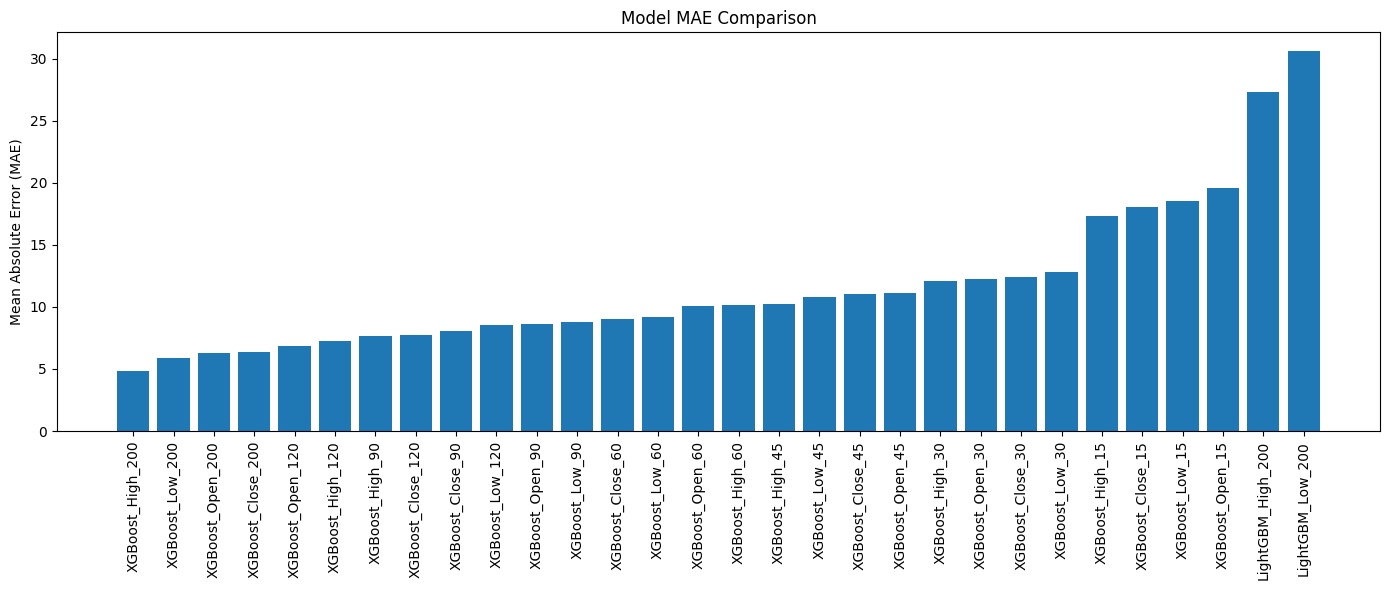

In [120]:
results_df = results_df.sort_values(by='mae')
results_df = results_df.head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(results_df['Model'], results_df['mae'])
plt.xticks(rotation=90)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model MAE Comparison')
plt.tight_layout()
plt.show()



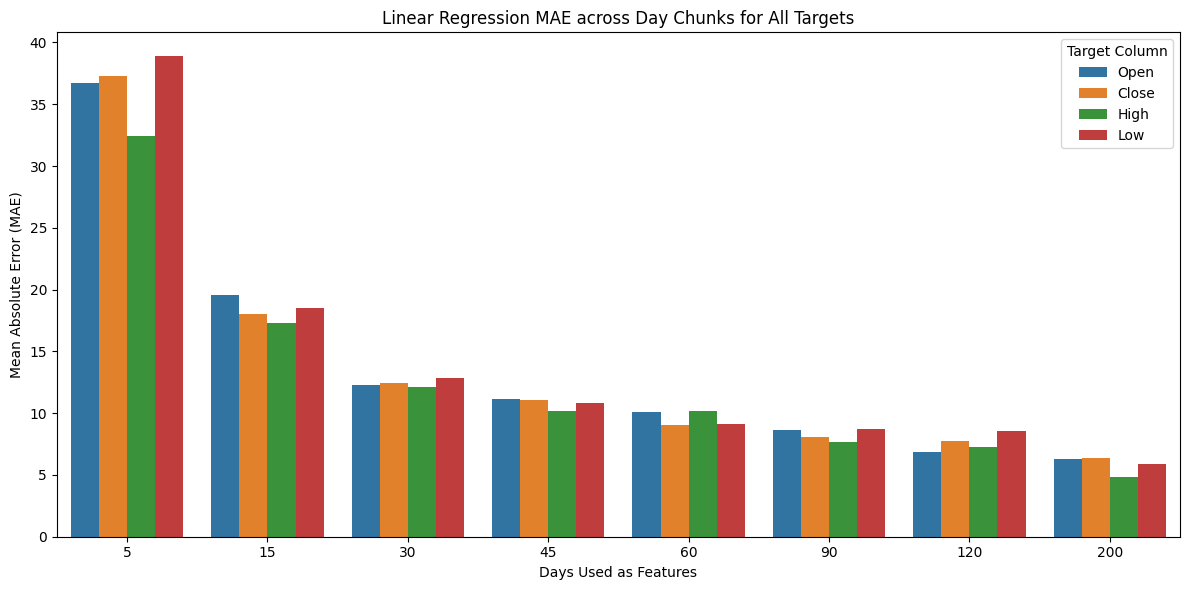

In [122]:
lr_results = {
    k: v for k, v in trained_models.items()
    if k.startswith("XGBoost")
}


lr_df = pd.DataFrame([
    {
        "Target": k.split('_')[1],        # Open / Close / High / Low
        "Days": int(k.split('_')[2]),     # 5, 15, ..., 200
        "MAE": v['mae']
    }
    for k, v in lr_results.items()
])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=lr_df, x="Days", y="MAE", hue="Target")

plt.title("Linear Regression MAE across Day Chunks for All Targets")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Days Used as Features")
plt.legend(title="Target Column")
plt.tight_layout()
plt.show()


In [125]:
model = trained_models['XGBoost_High_200']['model']